<h2>Using SAS DLPy to Create a VGG16 Deep Learning Model to Classify Superheroes in Retail Product Images</h2>


The following example uses SAS DLPy to create a CNN image classification model. The model task is to analyze input images of retail product offerings associated with one of 12 superheroes. The model predicts which superhero target class the retail image represents. 

This example uses the Super Heroes Dataset from Crowd Analytix at https://www.crowdanalytix.com/contests/identifying-superheroes-from-product-images. The data was scraped from SuperHeroDb and is released under CCO as public domain.

### Table of contents
1. Setup Libraries and Launch CAS
2. Load and Explore the Superhero Training Data
3. Prepare the Data for Modeling
4. Specify VGG16 Model Architecture, Configure Model Parameters, Import Pre-Trained Weights
5. Fit the VGG16 Image Detection and Classification Model
6. Score the Test Data to Predict Image Superhero Class
7. Visualize Model Leanring
8. Save VGG16 Model as ASTORE for Deployment

### Setup Libraries and Launch CAS

All examples require the SAS computing environment to be configured. This includes CAS (SAS Cloud Analytic Services) server sessions as well as Python requirements, including loading required DLPy functions and a plotting library.

SWAT is a Python interface to SAS CAS. For more information about starting a CAS session with the SWAT package, see https://sassoftware.github.io/python-swat/getting-started.html.

In [1]:
# Import Libraries
import swat
import dlpy
from dlpy.images import ImageTable
from dlpy.splitting import two_way_split
from dlpy.applications import *
from dlpy.utils import add_caslib
import warnings
warnings.filterwarnings('ignore')
import matplotlib
%matplotlib inline

After importing the required libraries and utilities, connect to SAS CAS. You will need to know the name of your CAS server and port ID, as well as your userID and password.

In [2]:
# Create CAS Connection   
conn = swat.CAS(hostname, portnum, userID, password)

Now specify a path where the model data and the model weights reside.

In [3]:
# Set Directory Path
dir_path = '/data/userID/superhero_classification/'

### Load and Explore the Superhero Training Data

Now use `load_files` from DLPy `ImageTable` to create a CAS table named `superTrain`. Load the model data contained in the subdirectory named `CAX_Superhero_Train` into the `superTrain` table. `CAX_Superhero_Train` is a subdirectory of the specified CASlib path: `/data/userID/Superhero_Classification_Model/CAX_Superhero_Train`. Labels are inherited from subdirectory names when you use `load_files`.

In [4]:
# Load Data into CAS
superTrain = ImageTable.load_files(conn, path=dir_path + 'CAX_Superhero_Train', casout=dict(name='superTrain'))

Now table `superTrain` is loaded with observations containing retail product images that have superhero content. Use `show()` to display a table of 10 randomly selected images, in two rows of 5 columns.

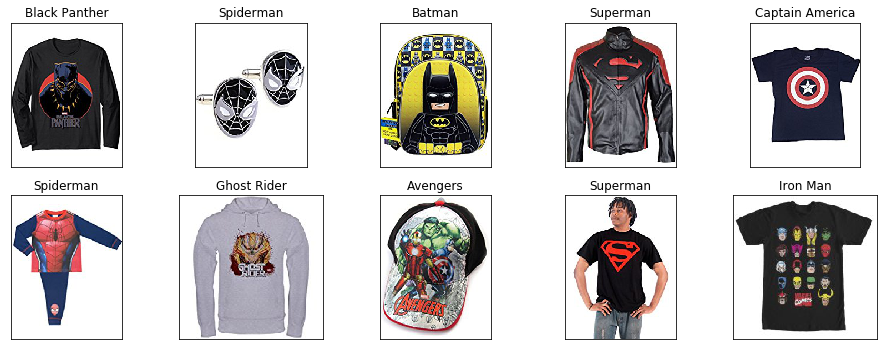

In [5]:
# Preview Images
superTrain.show(nimages=10, ncol=5, randomize=True)

The preview table indeed verifies that we have retail product images in table `superTrain`. Use the `label_freq()` function to verify there are entries from 12 superhero classes, and see the distribution of labeled images among the 12 superhero classes in the model data. 

In [6]:
# Label Frequency Table
superTrain.label_freq

,Level,Frequency
Ant-Man,1,241
Aquaman,2,201
Avengers,3,216
Batman,4,779
Black Panther,5,460
Captain America,6,410
Catwoman,7,200
Ghost Rider,8,200
Hulk,9,414
Iron Man,10,694


Now use `image_summary` to generate a summary table of the attributes of the images in the model data. How many images total? What is the range of image dimensions in the model data? 

In [7]:
# View Count, Width, Height, Min, Max, and Mean
superTrain.image_summary

jpg                  5433
minWidth               73
maxWidth              540
minHeight             120
maxHeight             522
meanWidth         197.982
meanHeight        230.795
mean1stChannel    167.516
min1stChannel           0
max1stChannel         255
mean2ndChannel     166.33
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    173.753
min3rdChannel           0
max3rdChannel         255
dtype: object

The table above shows the model images have heights that range from 120 to 522 pixels, and image widths that range from 73 to 540 pixels. To improve model performance, prepare the data. 

### Prepare the Data for Modeling

Now prepare the data to improve model performance. The data preparation task includes items such as shuffling images, splitting the data into train and test partitions, augmenting the train data with image patches, and standardizing image size. 

Begin by randomizing the order of the images in the table `superTrain`:

In [8]:
# Shuffle Images
superTrain.shuffle(casout=dict(name='superTrain', replace=True));

Now use the `two_way_split()` function to divide the model data into train and test partitions. Use random seed `12345`, and partition the data so that 80% of observations are allocated to the train partition `trainData` and 20% of observations are allocated to the test partition `testData`. 

In [9]:
# Split Training Data into Train / Test
trainData, testData = two_way_split(superTrain, test_rate=20, seed=12345)

Now augment the size of the training data set `trainData`. Use the `as_patches()` function to create 200 x 200 pixel image patches with a `step_size` of 24, resulting in new output image patches sized 224 x 224 pixels. Setting `inplace=True` replaces the original training data with the newly augmented and resized training data.

In [10]:
# Create Image 'Patches' to Increase Training Set
trainData.as_patches(width=200,
                     height=200,
                     step_size=24,
                     output_width=224,
                     output_height=224,
                     inplace=True)

All of the patch images created to augment the training data are 224 x 224. Use the `resize()` function to resize the test data images of varying dimensions to a standard image size of 224 x 224.

In [11]:
# Resize Test Data
testData.resize(width=224, height=224, inplace=True)

After standardizing all images in the `testData` partition, use `image_summary` to display a summary table of the image attributes in the augmented table.

In [12]:
# Augmented Training Image Summary
trainData.image_summary

jpg                 79463
minWidth              224
maxWidth              224
minHeight             224
maxHeight             224
meanWidth             224
meanHeight            224
mean1stChannel    157.613
min1stChannel           0
max1stChannel         255
mean2ndChannel     154.45
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    163.318
min3rdChannel           0
max3rdChannel         255
dtype: object

The updated table confirms that table `trainData` has been augmented and standardized. The table has increased from 5,433 images to 79,463 images. All images in `trainData` are standardized to a uniform 224 x 224 pixel size. 

Use the `show()` function to display a table of 10 random labeled retail product images in a table with 5 columns:

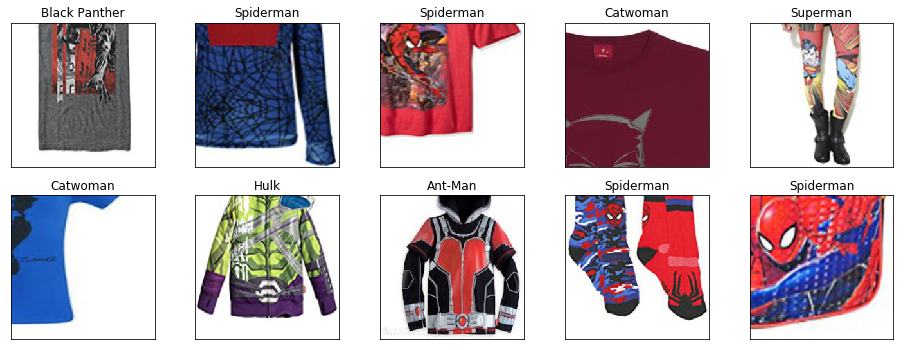

In [13]:
# Preview Perturbed Images
trainData.show(nimages=10, ncol=5, randomize=True)

### Specify VGG16 Model Architecture, Configure Model Parameters, Import Pre-Trained Weights

This example uses a pre-defined VGG16 model architecture with pre-trained weights to detect and classify the superheroes in retail product images. The model weights are saved in a Caffe format `.h5` file. The following code uses DLPy to create a VGG16 model named `model_vgg16` with a model architecture defined as `VGG16_notop`. The model architecture will have 12 classes in the final prediction layer. 

The code configures the model to process color images sized 244 x 244 pixels. The BGR (Blue, Green, Red) color offsets are stored in `trainData.channel_means`. The `image_summary` for this augmented data shows the channel_means values are 157.613 (B), 154.45 (G), and 163.318 (R).
  
The model is configured to use pre-trained weights, using the specified weight file `VGG_ILSVRC_16_layers.caffemodel.h5`, which is located in the pre-defined directory path `dir_path`.

Since the `model_vgg16` value for `include_top=False`, the imported model weights are loaded for all model layers except the final prediction layer.

Note: You can obtain the VGG16 model files used in this example from the SAS technical support web at by using the following URL: https://support.sas.com/documentation/prod-p/vdmml/zip/vgg16.zip.



In [14]:
# Use Popular VGG16 Model
# Loading Pre-Trained Weights from CAS Library
model_vgg16 = VGG16(
    conn,
    model_table='VGG16_notop',
    n_classes=12,
    n_channels=3,
    width=224,
    height=224,
    scale=1,
    offsets=trainData.channel_means,
    pre_trained_weights=True, 
    pre_trained_weights_file=dir_path + 'VGG_ILSVRC_16_layers.caffemodel.h5',
    include_top=False)

NOTE: Model weights attached successfully!
NOTE: Model table is attached successfully!
NOTE: Model is named to "vgg16_notop" according to the model name in the table.


Now you can look at the imported VGG16 model structure. The VGG16 model structure contains 16 layers. Use `print_summary()` to display a summary table of the `model_vgg16` model architecture.

In [15]:
model_vgg16.print_summary() # VGG16 b/c 16 Learnable Layers

,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters
0,data,input,None,None,None,"(224, 224, 3)","(0, 0)"
1,conv1_1,convo,"(3, 3)",1,Rectifier,"(224, 224, 64)","(1728, 64)"
2,conv1_2,convo,"(3, 3)",1,Rectifier,"(224, 224, 64)","(36864, 64)"
3,pool1,pool,"(2, 2)",2,Max,"(112, 112, 64)","(0, 0)"
4,conv2_1,convo,"(3, 3)",1,Rectifier,"(112, 112, 128)","(73728, 128)"
5,conv2_2,convo,"(3, 3)",1,Rectifier,"(112, 112, 128)","(147456, 128)"
6,pool2,pool,"(2, 2)",2,Max,"(56, 56, 128)","(0, 0)"
7,conv3_1,convo,"(3, 3)",1,Rectifier,"(56, 56, 256)","(294912, 256)"
8,conv3_2,convo,"(3, 3)",1,Rectifier,"(56, 56, 256)","(589824, 256)"
9,conv3_3,convo,"(3, 3)",1,Rectifier,"(56, 56, 256)","(589824, 256)"


Now use `plot_network()` to display a Directed Acyclic Graph (DAG) of the model architecture. VGG16 is a deep network which would add alot of scrolling to notebook. Uncomment and run to see the network

In [2]:
# Directed Acyclic Graph (DAG) of Popular VGG16 Model Architecture
# model_vgg16.plot_network()

### Fit the VGG16 Image Detection and Classification Model

Use `fit()` to train the CNN model `model_vgg16` and specify the model parameters. Use the training data `trainData` that was created and augmented earlier in the example. The `gpu` parameter enables the use of GPU2 during processing and offers the capability to pass multiple GPUs. The model uses 32 observations per thread in a mini-batch, using 4 threads. Training uses a learning rate of 0.001, and with a maximum of 5 epochs. Setting `log_level=2` configures the output to produce an iteration history. 

In [22]:
# Set Optimization and Algorithm Paramters
model_vgg16.fit(data=trainData,
                mini_batch_size=32,
                max_epochs=5,
                lr=0.001,
                gpu=dict(devices=[2]),
                n_threads=4,
                log_level=2);

NOTE: Either dataspecs or inputs need to be non-None, therefore inputs=_image_ is used
NOTE: Training based on existing weights.
NOTE: Only 1 out of 4 available GPU devices are used.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 134309708.
NOTE:  The approximate memory cost is 2093.00 MB.
NOTE:  Loading weights cost       0.21 (s).
NOTE:  Initializing each layer cost       2.76 (s).
NOTE:  The total number of threads on each worker is 4.
NOTE:  The total mini-batch size per thread on each worker is 32.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 128.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:     12
NOTE:  Levels for the target variable:
NOTE:  Level      0: Ant-Man        
NOTE:  Level      1: Aquaman        
NOTE:  Level      2: Avengers       
NOTE:  Level      3: Batman         
NOTE:  Level      4: Black Panther  
NOTE:  Level      5: Captain America
NOTE:  Level      6: 

You can see the list of 12 Superheros in the output. There is one level for each Superhero in the target variable. 

Now use `save()` to save the VGG16 model with augmented and standardized data and applied model weights in the CASlib as table `VGG16_NOTOP_WEIGHTS`, with the model name `super_hero_vgg16_weights`. If a model by that name exists, the old model will be overwritten.

In [25]:
# Save Model Your Weights
conn.save(table='VGG16_NOTOP_WEIGHTS',
          name='super_hero_vgg16_weights',
          replace=True);

NOTE: Cloud Analytic Services saved the file super_hero_vgg16_weights.sashdat in caslib CASUSER(sas).


Examine the model fit by using `plot_training_history()` to create a 15 x 5 plot display of the Loss and Fit Error for this model across training epochs:

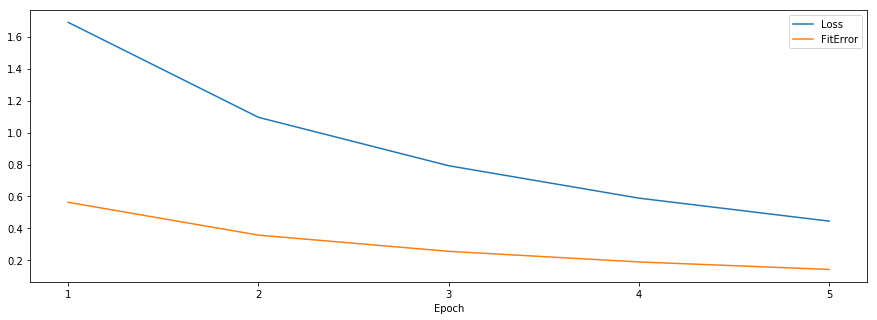

In [26]:
# Loss and Fit Error Over Epochs
model_vgg16.plot_training_history(items=('Loss','FitError'), fig_size=(15, 5))

### Score the Test Data to Predict Image Superhero Class

Use `predict()` to use `model_vgg16` to score the model data in `testData`. Two GPUs are enabled for processing.

The output includes tables that summarize model scoring parameters and the names of model output tables in CAS.

In [27]:
# Predict on Test, Misclassification Error %
model_vgg16.predict(data=testData, gpu=dict(devices=[0,1]))

NOTE: Only 2 out of 4 available GPU devices are used.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read          1086
 1  Number of Observations Used          1086
 2  Misclassification Error (%)      27.99263
 3                   Loss Error      0.999919

[OutputCasTables]

          casLib              Name  Rows  Columns  \
 0  CASUSER(sas)  Valid_Res_YUsvm3  1086       19   
 
                                             casTable  
 0  CASTable('Valid_Res_YUsvm3', caslib='CASUSER(s...  

+ Elapsed: 5.03s, user: 10.4s, sys: 2.21s, mem: 2.51e+03mb

The model scored the data in the test partition and misclassified 304 of 1086 images for an overal misclassification rate of 28.0%. The remaining 782 images in the test data were correctly classified.

### View Scored Superhero Image Examples

Let's look at a few example images from the scored data, and see how the model evaluated the classification. Images are selected by random and the class value for the classification `img_type` attribute. The `img_type` attribute values are `C`, `M`, or `A`. 

Scored images that are `img_type='C'` are correctly classified images. Scored images that are `img_type='M'` are misclassified images. The `img_type='A'` class returns all scored images, whether correctly classified or misclassifed.

The following code uses `plot_evaluate_res()` to view two correctly classified images selected at random from scored `model_vgg16` data:

NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(sas).


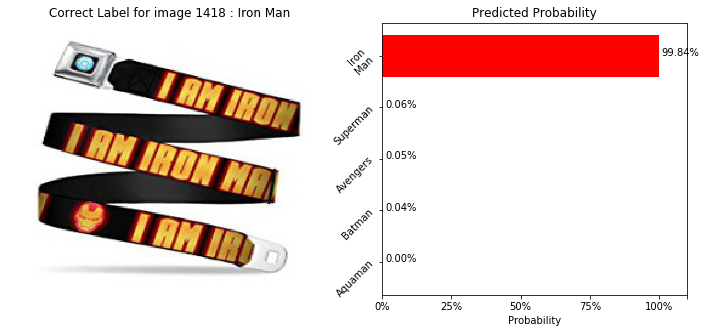

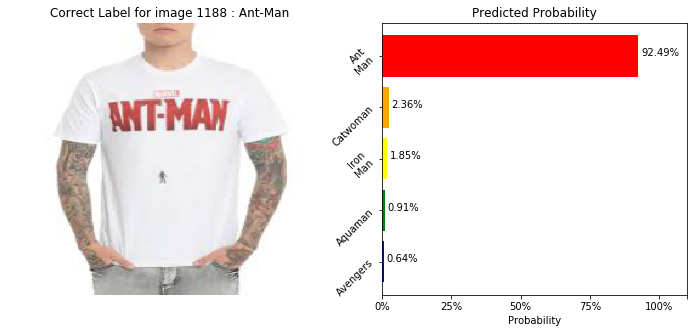

In [28]:
model_vgg16.plot_evaluate_res(img_type='C', randomize=True, n_images=2)

These 2 images were correctly classified as Iron Man and Ant-Man with a 99.84% and 92.49% probability.

NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(sas).


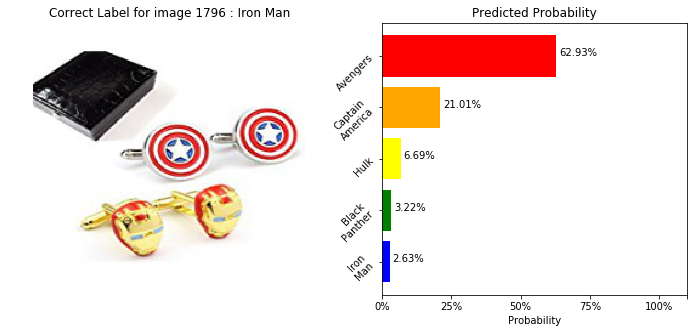

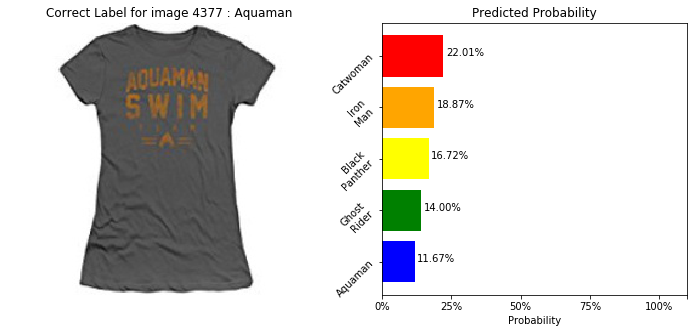

In [30]:
model_vgg16.plot_evaluate_res(img_type='M', randomize=True, n_images=2)

These 2 images were misclassified as Avengers and Cat Woman with a 62.93%% and 22.01% probability.

### Visualize Model Learning

You can visualize model learning using heat, feature, and activation maps.

#### Visualization through Heat Maps

Heat maps look at individual pixels in an image and assesses how removing that pixel from the image impacts the probability of a correct classification. The higher the temperature of a pixel (or group of pixels) in a heat map, the more important the pixel information is for classification.  The following code uses `heat_map_analysis()` with `model_vgg16` to create heat maps of observations in `testData`, using a 56 x 56 pixel mask and a step size of 8 to generate the maps. 

Using results from model.predict()
NOTE: The number of images in the table is too large, only 3 randomly selected images are used in analysis.
NOTE: Table SAMPLE_TBL_T5MADW contains compressed images.


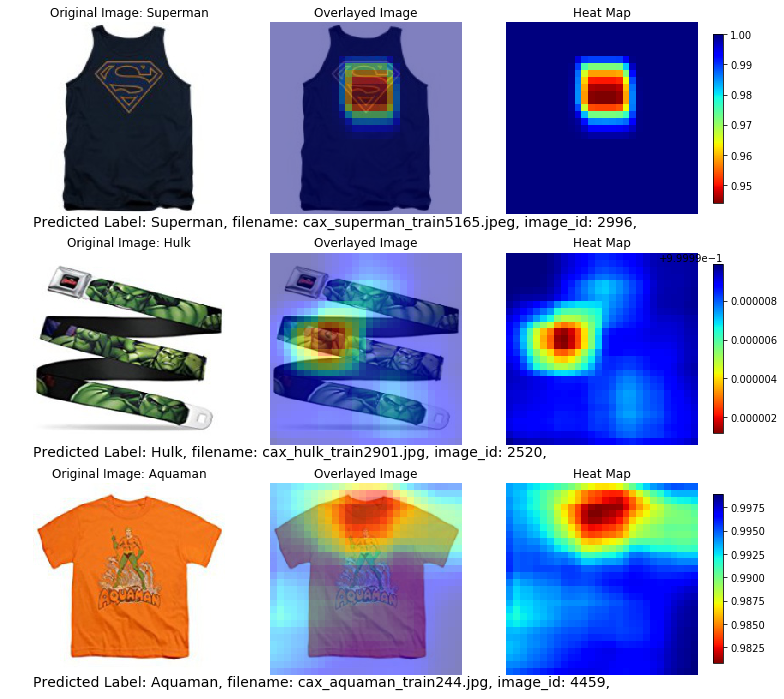

NOTE: Cloud Analytic Services dropped table SAMPLE_TBL_T5mAdW from caslib CASUSER(sas).


In [31]:
# Generate Heat Map for test data images 
model_vgg16.heat_map_analysis(mask_width=56, mask_height=56, step_size=8, max_display=3);

You can see in the output images above how the heat map temperatures correspond to image areas that are most useful for determining the correct Superhero class. Each heat map output row displays three images: the source image by itself, the source image with the heat map overlaid, and the heat map by itself.

#### Visualization Through Feature Maps

Feature maps are created by moving a lens across an image searching for features that when combined, might signal a larger, more complex feature. CNN networks define feature importance during learning. Feature maps from early layers of a CNN are typically lower level features such as a line or arc. Subsequent layer feature maps might combine images into shapes such as circles and lines. The next feature map could detect an automobile from lines and circle features. The following code uses `get_feature_maps()` with `model_vgg16` to generate feature maps of the third image (0,1,2) in the `testData` data labeled as `Iron Man`.

In [32]:
model_vgg16.get_feature_maps(data=testData, label='Iron Man', idx=2)

The next line of code uses `feature_maps.display()` to display the Iron Man feature map for layer 0, which is the input layer:

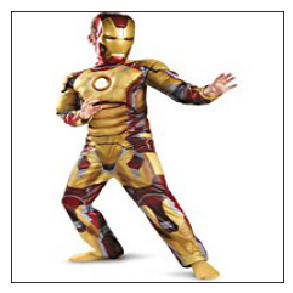

In [33]:
model_vgg16.feature_maps.display(layer_id=0)

#### Visualization Through Activation Maps

Activation maps display the output activations in a model layer. They indicate the discriminative image regions that the CNN uses to identify a class (Superhero) category. A high activation indicates that a certain feature was found. The following code uses `feature_maps.display()` to visualize the activations and layer_1 weights of `model_vgg16` during the forward pass:

Here is the activation map for layer_1 of the VGG16 model:

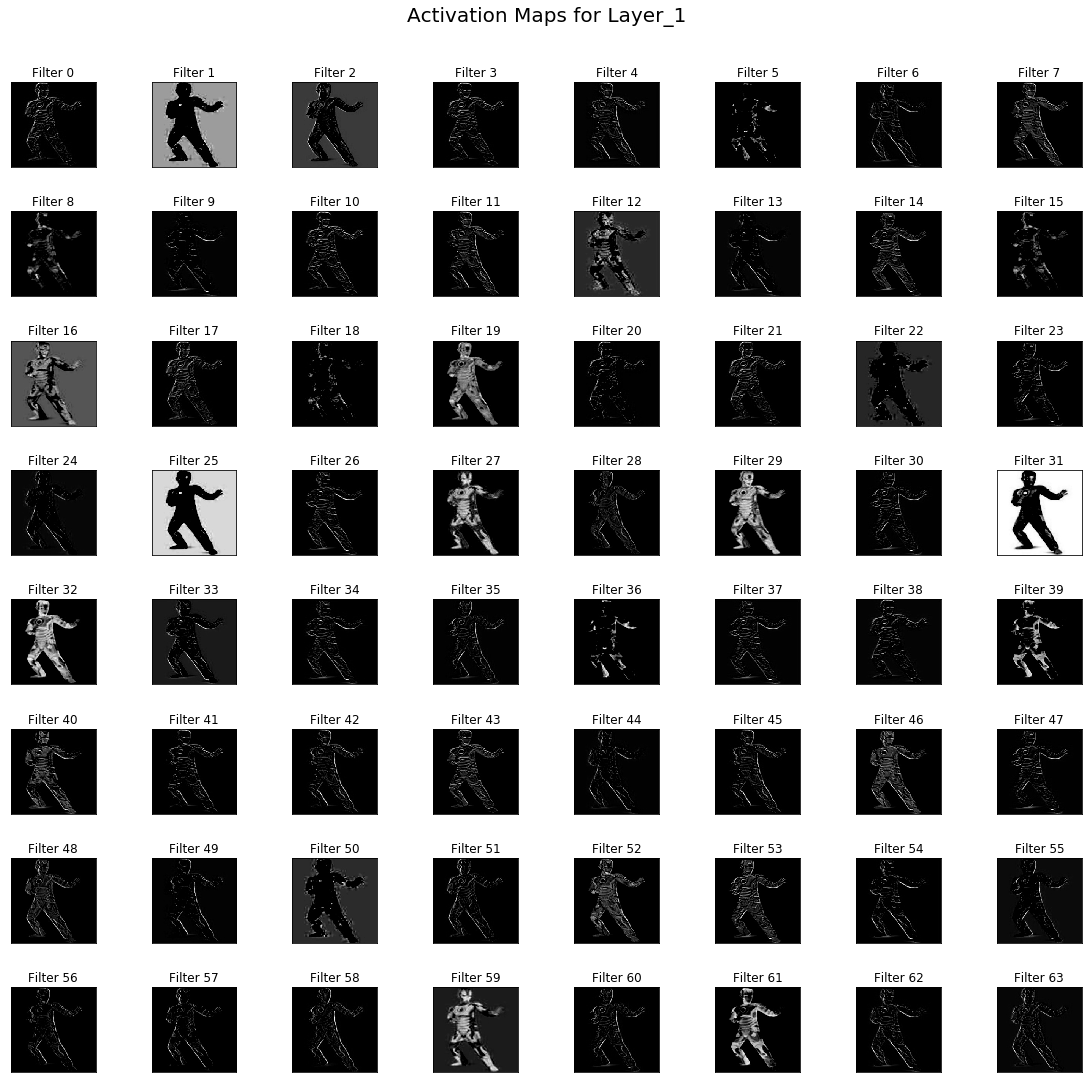

In [34]:
model_vgg16.feature_maps.display(layer_id=1)

The following code uses `feature_maps.display()` to visualize the activations and layer_2 weights of `model_vgg16`. Here is the activation map for layer_2 of the VGG16 model:

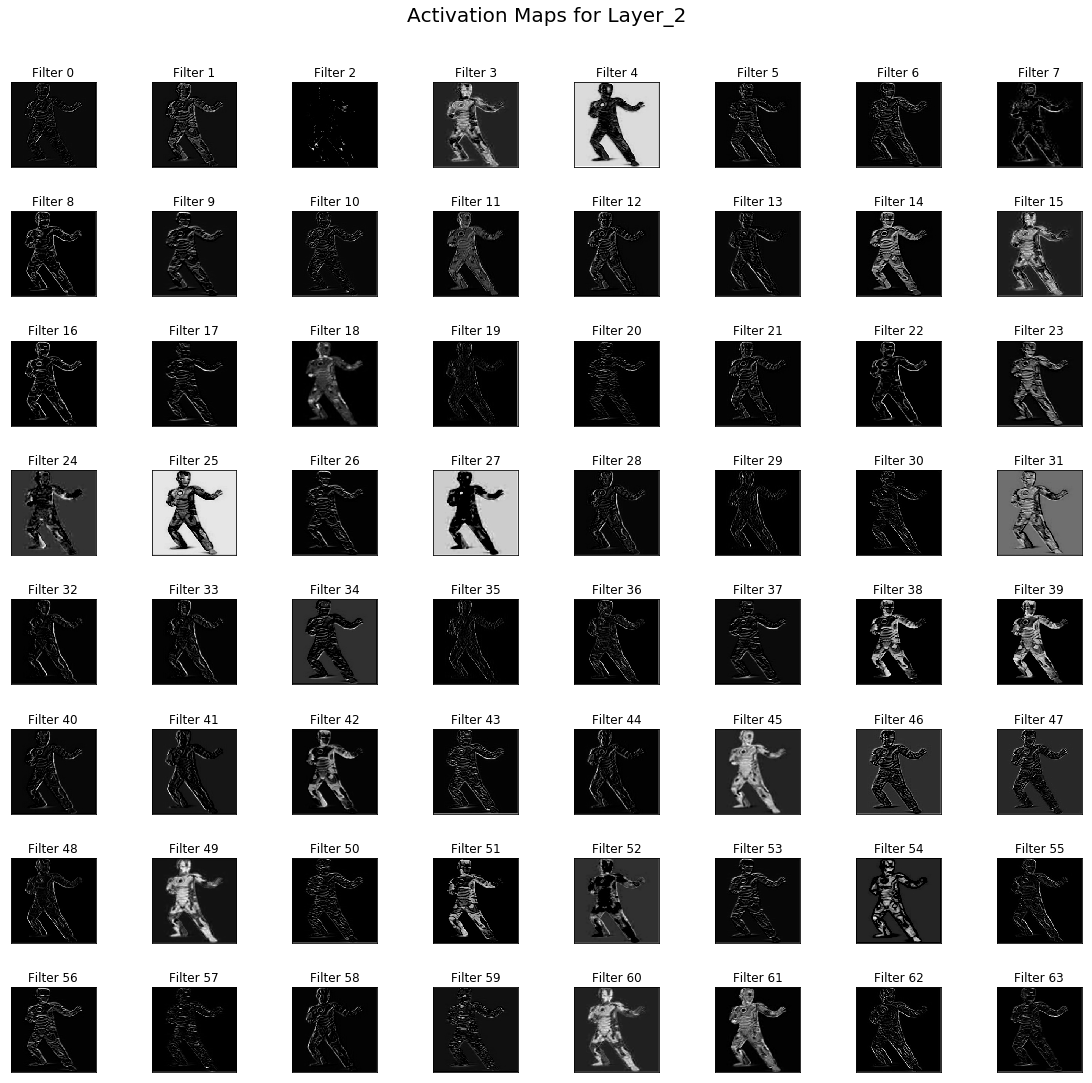

In [35]:
model_vgg16.feature_maps.display(layer_id=2)

### Save VGG16 Model as ASTORE for Deployment

The following code saves `model_vgg16` to the specified path as an ASTORE for deployment. 

In [36]:
# Save Model as astore for Deployment
model_vgg16.deploy(path='/data/userID/superhero_classification/', output_format='astore')

NOTE: Model astore file saved successfully.
